In [1]:
# Package Imports
import pandas as pd
import numpy as np
import pickle

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

from imblearn.pipeline import Pipeline as ImPipeline

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import Tokenizer

# Modeling

In [2]:
max_features = 100000

In [3]:
# Read in the data
df = pd.read_csv('../data/train_cleaned.csv', usecols=['sentiment', 'text_cleaned', 'toks', 'trigrams'])

In [4]:
df.head(25)

,sentiment,text_cleaned,toks,trigrams
0,2,sound track beautiful paint senery mind well w...,"['sound', 'track', 'beautiful', 'paint', 'sene...","[('sound', 'track', 'beautiful'), ('track', 'b..."
1,2,i'm reading lot review say best game soundtrac...,"[""i'm"", 'reading', 'lot', 'review', 'say', 'be...","[(""i'm"", 'reading', 'lot'), ('reading', 'lot',..."
2,2,soundtrack favorite music time hand intense sa...,"['soundtrack', 'favorite', 'music', 'time', 'h...","[('soundtrack', 'favorite', 'music'), ('favori..."
3,2,truly like soundtrack enjoy video game music p...,"['truly', 'like', 'soundtrack', 'enjoy', 'vide...","[('truly', 'like', 'soundtrack'), ('like', 'so..."
4,2,played game know divine music every single son...,"['played', 'game', 'know', 'divine', 'music', ...","[('played', 'game', 'know'), ('game', 'know', ..."
5,2,quite sure actually take time read played game...,"['quite', 'sure', 'actually', 'take', 'time', ...","[('quite', 'sure', 'actually'), ('sure', 'actu..."
6,1,self publish book want know read paragraphs st...,"['self', 'publish', 'book', 'want', 'know', 'r...","[('self', 'publish', 'book'), ('publish', 'boo..."
7,2,love whisper wicked saint story amaze pleasant...,"['love', 'whisper', 'wicked', 'saint', 'story'...","[('love', 'whisper', 'wicked'), ('whisper', 'w..."
8,2,finish reading whisper wicked saint fell love ...,"['finish', 'reading', 'whisper', 'wicked', 'sa...","[('finish', 'reading', 'whisper'), ('reading',..."
9,2,easy read book make want keep reading easy put...,"['easy', 'read', 'book', 'make', 'want', 'keep...","[('easy', 'read', 'book'), ('read', 'book', 'm..."


In [5]:
print(df.isna().sum())
df[df['text_cleaned'].isna()]

sentiment        0
text_cleaned    19
toks             0
trigrams         0
dtype: int64


,sentiment,text_cleaned,toks,trigrams
217919,2,NaN,[],[]
294435,2,NaN,[],[]
629878,1,NaN,[],[]
680354,2,NaN,[],[]
1440939,1,NaN,[],[]
1786231,2,NaN,[],[]
1989004,2,NaN,[],[]
2005370,1,NaN,[],[]
2071299,2,NaN,[],[]
2220519,2,NaN,[],[]


In [8]:
# Drop rows with missing text_cleaned values
df.dropna(inplace=True)

In [9]:
X = df['text_cleaned']
y = df['sentiment']

In [10]:
# Instantiate Dummy Classifier pipeline
dummy_pipe = ImPipeline(steps=[
                                ('vect', TfidfVectorizer(max_features=max_features)),
                                ('dc', DummyClassifier(strategy='most_frequent',
                                                           random_state=42))
                              ]
)

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.5000006944481096


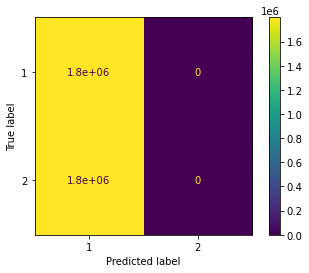

In [11]:
# Fit dummy pipe on the training data and plot confusion matrix
dummy_pipe.fit(X, y)
dummy_yhat = dummy_pipe.predict(X)
plot_confusion_matrix(dummy_pipe, X, y);
print(accuracy_score(y, dummy_yhat))

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.8200618281040928


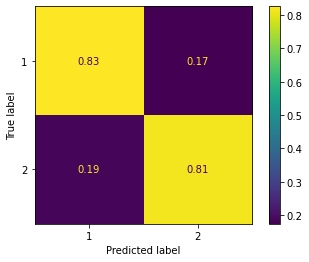

In [15]:
# Instantiate the Multinomial Naieve Bayes Pipeline
mnb_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features)),
                            ('mnb', MultinomialNB())
                            ]
)

# Fit MNB pipe on the training data, get predictions and plot confusion matrix
mnb_pipe.fit(X, y)
mnb_yhat = mnb_pipe.predict(X)
plot_confusion_matrix(mnb_pipe, X, y, normalize='true');
print(accuracy_score(y, mnb_yhat))

In [13]:
mnb_pipe.named_steps['mnb'].n_features_
#__mnb.n_features_

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


100000

In [14]:
# Obtained cross-validated accuracy score
cross_validate(mnb_pipe, X, y)

{'fit_time': array([62.13884497, 61.7850492 , 62.02747703, 62.03161287, 61.89556217]),
 'score_time': array([16.25729895, 16.04060602, 15.91219211, 15.74802613, 15.81075191]),
 'test_score': array([0.81789646, 0.81439341, 0.81300313, 0.81050867, 0.81168923])}

In [ ]:
# Instantiate the Random Forest Pipeline
rf_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features)),
                            ('rf', RandomForestClassifier())
                            ]
)

# Fit RF pipe on the training data, get predictions and plot confusion matrix
# rf_pipe.fit(X, y)
rf_yhat = rf_pipe.predict(X)
plot_confusion_matrix(rf_pipe, X, y);
print(accuracy_score(y, rf_yhat))

In [ ]:
# Obtained cross-validated accuracy score
# cross_validate(rf_pipe, X, y)

In [ ]:
with open ('rf_pkl', 'wb') as files:
    pickle.dump(rf_pipe, files)

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.8522014421742782


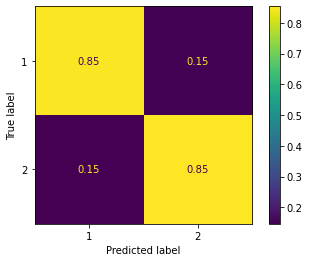

In [16]:
# Instantiate the SDGC Classifier pipeline
sgdc_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features,
                                                    #max_df=0.95,
                                                   # min_df=0.05
                                                    )),
                            ('sgdc', SGDClassifier(random_state=42))
                            ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_pipe.fit(X, y)
sgdc_yhat = sgdc_pipe.predict(X)
plot_confusion_matrix(sgdc_pipe, X, y, normalize='true');
print(accuracy_score(y, sgdc_yhat))

In [17]:
# Obtained cross-validated accuracy score
cross_validate(sgdc_pipe, X, y)

{'fit_time': array([68.95836902, 68.93960977, 70.01590133, 69.20251417, 69.27705789]),
 'score_time': array([16.33984685, 16.05096602, 15.98277092, 15.80469513, 15.93526602]),
 'test_score': array([0.84999104, 0.8502825 , 0.85179779, 0.85199501, 0.85184501])}

In [18]:
sgdc_params = {
            'sgdc__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 0.0002, 0.0005],
            #'sgdc__n_iter': [50, 100, 500],
            'sgdc__loss': ['hinge', 'log', 'huber'],
            'sgdc__penalty': ['l2', 'l1', 'elasticnet'],
            'vect__max_features': [None, 50000, 100000, 200000]
             }

In [19]:
sgdc_gs = GridSearchCV(sgdc_pipe, param_grid=sgdc_params, n_jobs=-2, verbose=3, cv=3)
sgdc_gs.fit(X, y)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_features=100000)),
                                       ('sgdc',
                                        SGDClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'sgdc__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0, 1000.0, 0.0002, 0.0005],
                         'sgdc__loss': ['hinge', 'log', 'huber'],
                         'sgdc__penalty': ['l2', 'l1', 'elasticnet'],
                         'vect__max_features': [None, 50000, 100000, 200000]},
             verbose=3)

In [20]:
sgdc_gs.best_params_

{'sgdc__alpha': 0.0001,
 'sgdc__loss': 'hinge',
 'sgdc__penalty': 'l2',
 'vect__max_features': 50000}

/Users/tom/opt/anaconda3/envs/spark-cap-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.8524669991313844


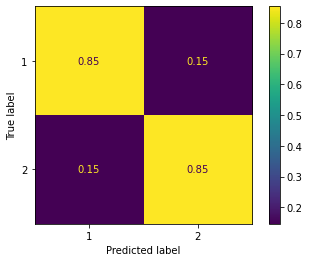

In [21]:
# Instantiate the SDGC Classifier pipeline
sgdc_tuned_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=50000,
                                                    #max_df=0.95,
                                                   # min_df=0.05
                                                    )),
                            ('sgdc', SGDClassifier(random_state=42,
                                                  alpha=0.0001,
                                                  loss = 'hinge',
                                                  penalty='l2'
                                                  ))
                            ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_tuned_pipe.fit(X, y)
sgdc_tuned_yhat = sgdc_tuned_pipe.predict(X)
plot_confusion_matrix(sgdc_tuned_pipe, X, y, normalize='true');
print(accuracy_score(y, sgdc_tuned_yhat))

In [ ]:
# Instantiate the gradient boosting classifier pipeline
gbc_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('gbc',  GradientBoostingClassifier())
                                ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
gbc_pipe.fit(X, y)
gbc_yhat = gbc_pipe.predict(X)
plot_confusion_matrix(gbc_pipe, X, y);
print(accuracy_score(y, gbc_yhat))

In [ ]:
# Obtained cross-validated accuracy score
cross_validate(gbc_pipe, X, y)